# Simulated Sky Signal in map domain

This lesson is about simulating the input sky signal using PySM 3.

## PySM 3

If you used `PySM` in the past, you most probably used `PySM 2` from https://github.com/bthorne93/PySM_public.

`PySM 3` is a rewrite of `PySM` which offers all the same functionality and the same models of `PySM 2` but is focused on:

* improving performance using just-in-time compilation and multi-threading with `numba`
* lowering memory requirements by reworking the underlying algorithms
* improved capability of running in parallel with MPI

It is available from https://github.com/healpy/pysm, it is still missing a few models and the documentation but is already integrated into TOAST to overcame the strong performance limits of `PySM 2`.

If anyone is interested in learning more about PySM 3, check the [PySM 3 tutorial](https://github.com/zonca/pysm_tutorial), we can work through this during the hack day.

## PySMSky

The lower level TOAST class is `PySMSky`, it performs the following operations:
* initialize `PySM` with the input sky configuration
* loop through all channels and for each calls `PySM` to generate the sky emission at all frequencies in the bandpass and integrate

In [1]:
# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    fake_focalplane
)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

In [2]:
import toast
import healpy as hp
import numpy as np

In [3]:
env = toast.Environment.get()                         
env.set_log_level("DEBUG")

In [4]:
focal_plane = fake_focalplane()

In [5]:
from toast.todmap import PySMSky
PySMSky?

Init signature:
PySMSky(
    comm=None,
    pixels='pixels',
    out='pysm',
    nside=None,
    pysm_sky_config=None,
    pysm_precomputed_cmb_K_CMB=None,
    pysm_component_objects=None,
    init_sky=True,
    pixel_indices=None,
    units='K_CMB',
    map_dist=None,
)
Docstring:     
Create a bandpass-integrated sky map with PySM

Requires PySM 3. It initializes the `pysm.Sky` object either
in the constructor (`init_sky=True`) or when the `exec` method
is executed (`init_sky=False`).
Inizialization of the sky will load templates from the first process
of the MPI communicator, copy to all processes and then select the local
rings, distributed as required by `libsharp` for eventual smoothing later.
If another pixel distribution is required, it can be specified with `pixel_indices`,
however a different pixel distribution can only be used if performing no smoothing.

Args:
    comm (mpi4py.MPI.Comm): MPI communicator
    pixels (str): the name of the cache object (<pixels>_<detector>)
 

In [6]:
NSIDE = 64
npix = hp.nside2npix(NSIDE)

### PySM models

You can find out details about all the models available in PySM 2 and 3 at:

https://pysm-public.readthedocs.io/en/latest/models.html

In [7]:
pysm_sky_config = ["s1", "f1", "a1", "d1"]

In [8]:
pysm_sky = PySMSky(comm=None,
       pixel_indices=None,
       nside=NSIDE,
       units="uK_RJ",
       pysm_sky_config=pysm_sky_config
)

In [9]:
pysm_sky

### PySM Sky object

We can directly access the underlying `PySM.Sky` object as the `sky` attribute of the `PySMSky` object.

In [10]:
pysm_sky.sky

In [11]:
import pysm.units as u

In [12]:
pysm_sky.sky.get_emission(12 * u.GHz)

<Quantity [[ 5.9475165e+02,  4.7780170e+02,  4.6408673e+02, ...,
             4.2369739e+02,  4.9087775e+02,  4.7881104e+02],
           [-1.0309416e+01, -2.0714520e+01, -2.8465218e+01, ...,
            -1.3051515e+00, -1.3430266e+01,  1.2164834e-02],
           [-1.4353321e+01,  1.5995528e+01,  4.7251720e+00, ...,
            -2.0496000e+01,  1.1566074e+01, -2.3161991e+01]] uK_RJ>

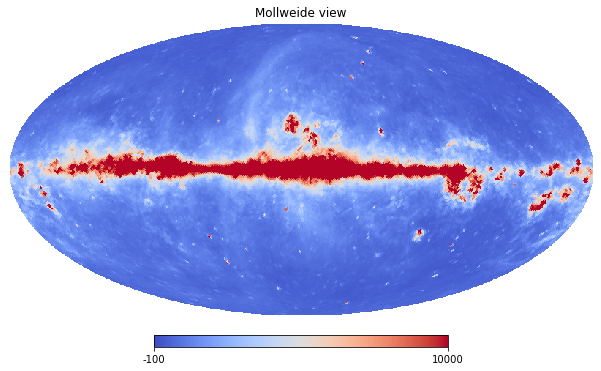

In [13]:
%matplotlib inline
## _ refers to the output of the previous cell, so this works only if you run cells in sequence
hp.mollview(_[0], cmap="coolwarm", min=-100, max=1e4)

### Execute the PySMSky object

First we need bandpasses for the channels, first element of the tuple is frequency, second element are weights, we define a top-hat of 10 points with a bandwidth of 10 GHz:

In [17]:
bandpasses = {}
for ch in focal_plane: # loops through dict keys
    bandpasses[ch] = (np.linspace(65, 75, 10), np.ones(10))  # bandpass is defined by a tuple, one with the frequencies and the other 
    #with the weight. This is just a tophat bandpass

In [15]:
bandpasses

{'0A': (array([65.        , 66.11111111, 67.22222222, 68.33333333, 69.44444444,
         70.55555556, 71.66666667, 72.77777778, 73.88888889, 75.        ]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])),
 '0B': (array([65.        , 66.11111111, 67.22222222, 68.33333333, 69.44444444,
         70.55555556, 71.66666667, 72.77777778, 73.88888889, 75.        ]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])),
 '1A': (array([65.        , 66.11111111, 67.22222222, 68.33333333, 69.44444444,
         70.55555556, 71.66666667, 72.77777778, 73.88888889, 75.        ]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])),
 '1B': (array([65.        , 66.11111111, 67.22222222, 68.33333333, 69.44444444,
         70.55555556, 71.66666667, 72.77777778, 73.88888889, 75.        ]),
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])),
 '2A': (array([65.        , 66.11111111, 67.22222222, 68.33333333, 69.44444444,
         70.55555556, 71.66666667, 72.77777778, 73.88888889, 75.        ]),
  array([1.,

In [18]:
local_maps = {}
pysm_sky.exec(local_maps, out="sky", bandpasses=bandpasses)

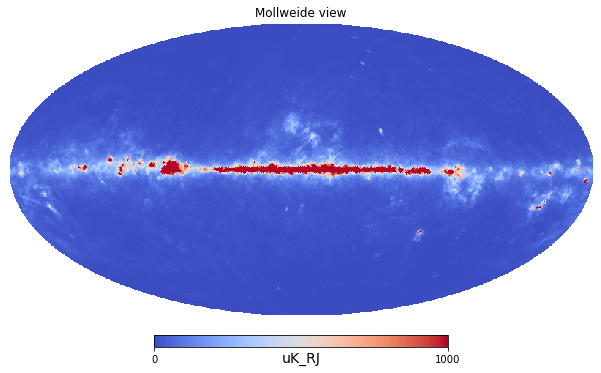

In [28]:
hp.mollview(local_maps["sky_0A"][0], cmap="coolwarm", min=0, max=1e3, unit="uK_RJ")

In [20]:
local_maps["sky_0B"][0]-local_maps["sky_0A"][0]  #the maps are the same because they have the same bandpass

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [21]:
bandpasses["0B"] = (np.linspace(63, 73, 10), np.ones(10)) #changed B's bandpass, see how it changes things

In [22]:
local_maps = {}
pysm_sky.exec(local_maps, out="sky", bandpasses=bandpasses)

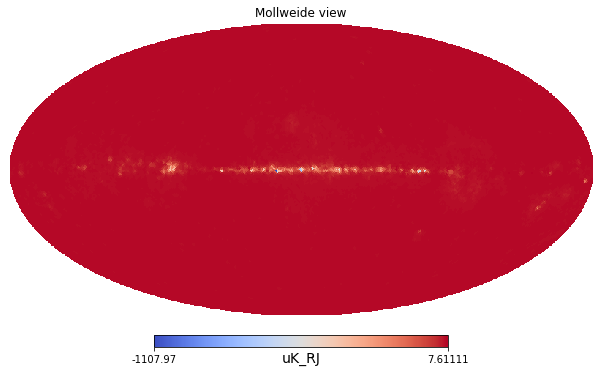

In [23]:
hp.mollview(local_maps["sky_0A"][0]-local_maps["sky_0B"][0], cmap="coolwarm", unit="uK_RJ") #ploting the difference between the two
#they now have slightly different bandpasses, they see two different skys. This can leak into polarization
#some sources in B clearly have a higher emission along the galaxy

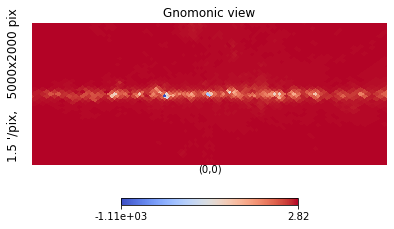

In [24]:
hp.gnomview(local_maps["sky_0A"][0]-local_maps["sky_0B"][0], rot=(0,0), xsize=5000, ysize=2000, cmap="coolwarm")